# Denoising Diffusion Probabilistic Models


In [1]:
import torch
import numpy as np
import random
from torch import nn,tensor
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchmetrics.classification import MulticlassAccuracy 
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import OneCycleLR
from torch.nn import init
import fastcore.all as fc
from lib import *
from pathlib import Path

/home/marconobile/miniconda3/envs/fastai_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To make life simpler (mostly with the model architecture), we'll resize the 28x28 images to 32x32:



In [2]:
set_seed(42)
device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

x,y = 'image','label'
dsd = load_dataset("fashion_mnist")

@inplace
def transformi(b): 
    b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train

xb,yb = next(iter(dt))
xb.shape,yb[:10]

/home/marconobile/miniconda3/envs/fastai_venv/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Using the latest cached version of the module from /home/marconobile/.cache/huggingface/modules/datasets_modules/datasets/fashion_mnist/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48 (last modified on Mon Dec 11 19:19:33 2023) since it couldn't be found locally at fashion_mnist., or remotely on the Hugging Face Hub.
/home/marconobile/miniconda3/envs/fastai_venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop

(torch.Size([128, 1, 32, 32]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

In [4]:
xb.shape

torch.Size([128, 1, 32, 32])

In [5]:
xb.min(), xb.max()

(tensor(0.), tensor(0.9997))

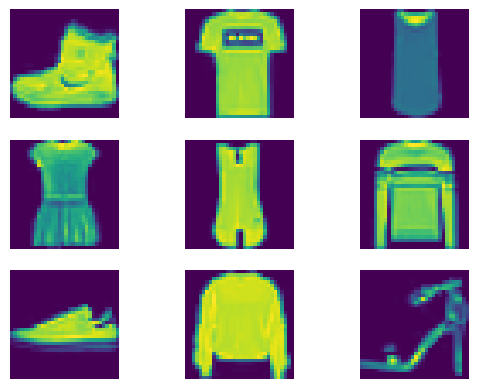

In [6]:
showImgGroup([xb[i, 0] for i in range(10)], (3,3))

# U-Net

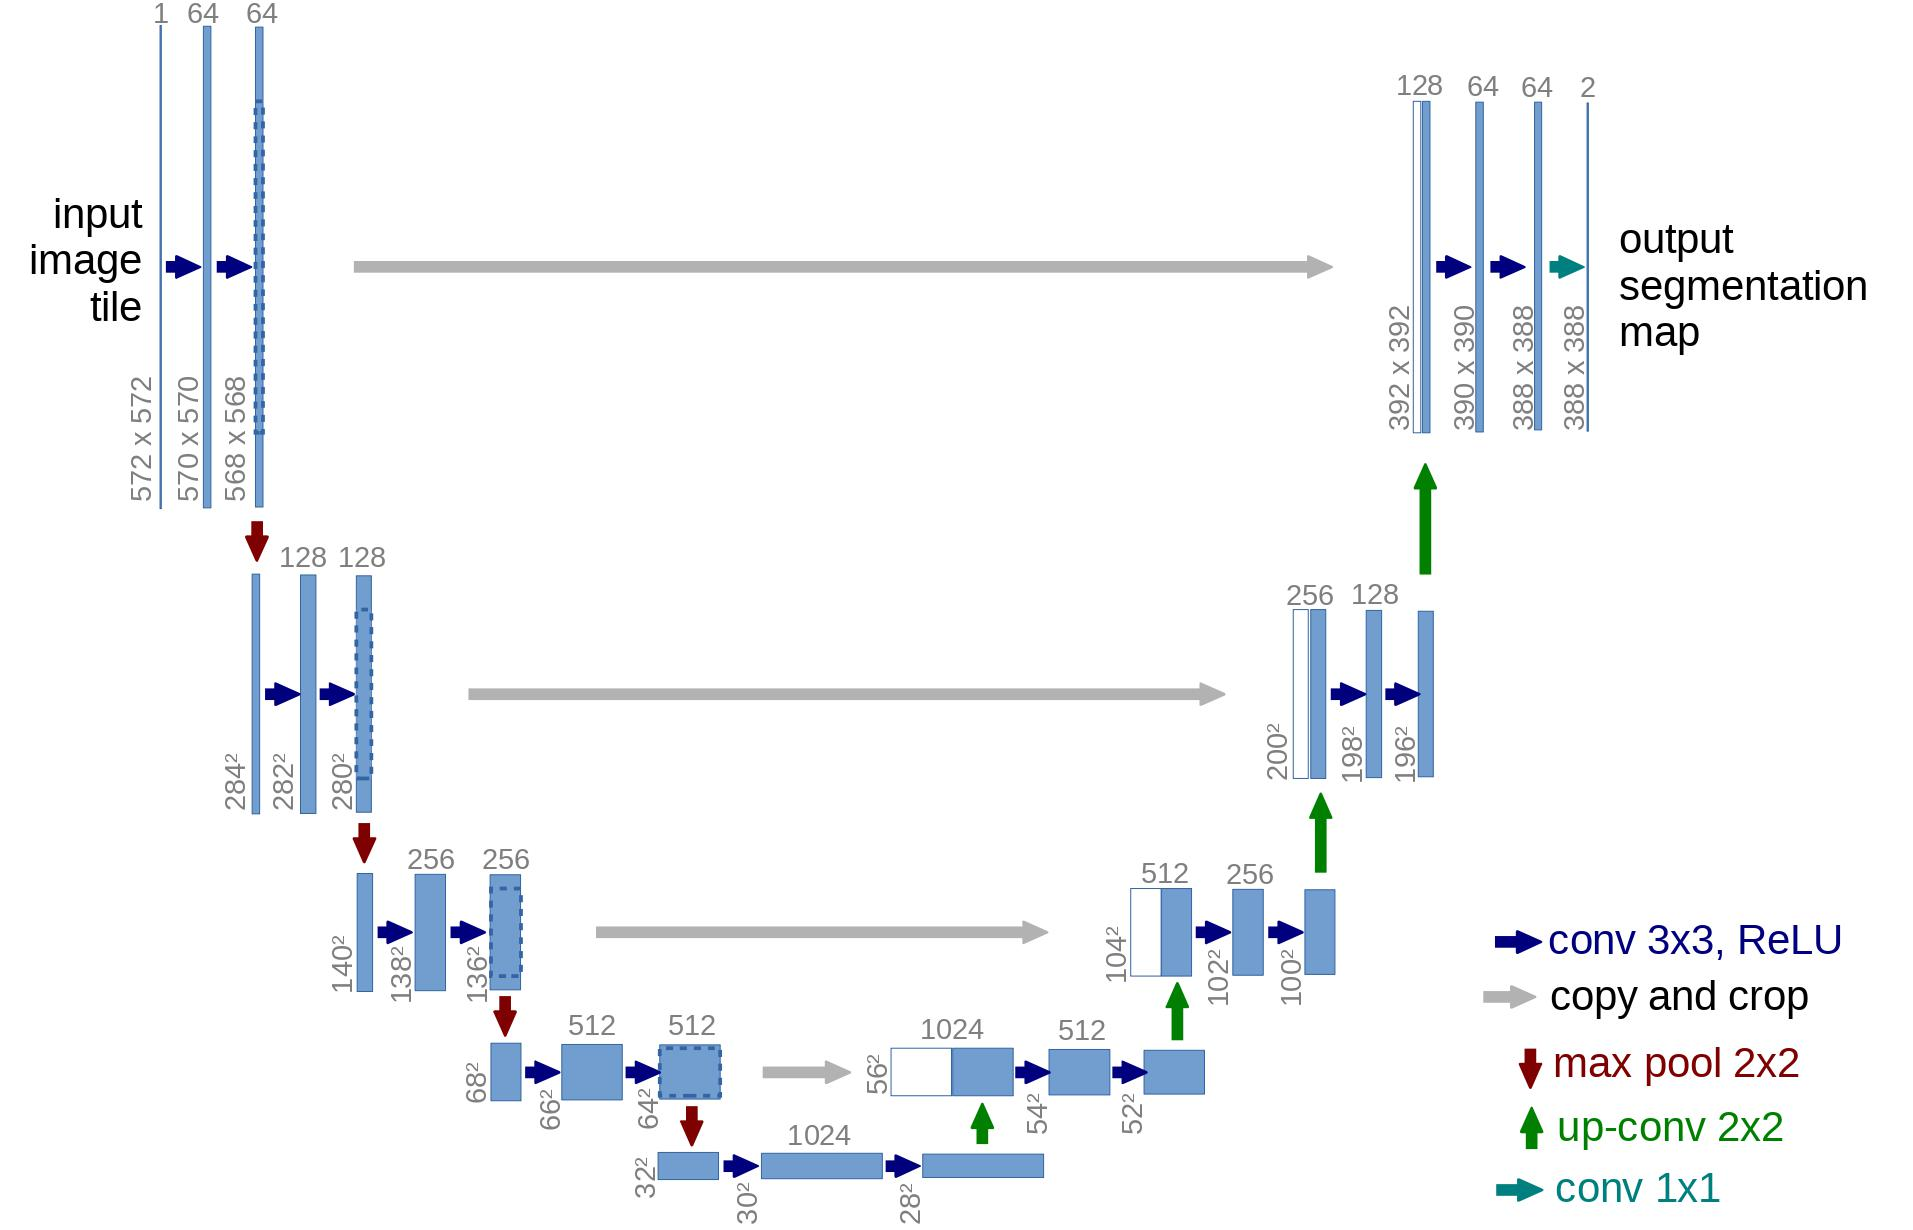

In [7]:
from IPython.display import Image
Image(filename="./unet.jpg")

We will cover how U-nets are created and how modules like attention work in future lessons. For now, we'll import the U-net from the diffusers library:

In [9]:
#!pip install diffusers
from diffusers import UNet2DModel
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

DDPM is trained in a few steps:

1) randomly select some timesteps in an iterative noising process:
    select a t -> this t defines the value of the parameter beta
    used to compute the target mean


2) Add noise corresponding to the value of beta of this timestep t to the original image. For increasing timesteps, the variance of the noise increases.


3) Pass in this noisy image and the timestep to our model as input


4) Model is trained with an MSE loss between the model output and the amount of noise added to the image as target

So for now let's take the model for given as a black box.
We will implement this in a callback. The callback will randomly select the timestep and create the noisy image before setting up our input and ground truth tensors for the model forward pass and loss calculation.
This version of DDPM is the 2020 paper introducing DDPMs that made some crucial assumptions that significantly simplify the model training and generation processes, as we will see here. Later versions of diffusion models all build upon the same framework introduced in this paper.
This generation is not conditionated wrt labels.

High timestep = lot of noise \
low timestep = low noise

Let's take a look at the trajectories of the parameter at play:

In [10]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
sigma = beta.sqrt()

alpha = 1.-beta # alpha = weight that defines of how much of the original img we keep
alphabar = alpha.cumprod(dim=0)

## Beta: linspace(betamin=0.0001, betamax=0.02, n_steps=1000)

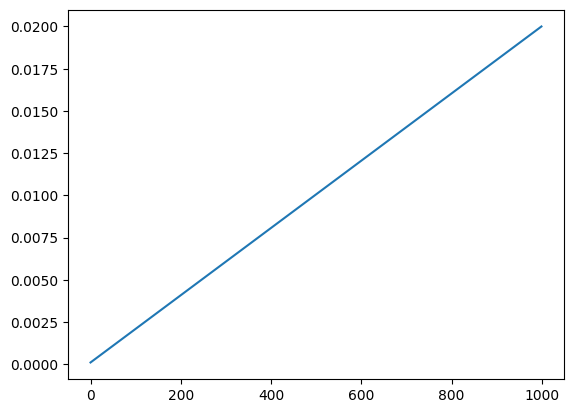

In [12]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
plt.plot(beta); # ammount of variance of the noise at each step

# in:
# x_t = N( (1-b_t).sqrt() * x_t-1 , b_t*I )
# low bt (close to 0) = all original img
# -> "ammount of variance of the noise at each step"
# inverse measure of how much of the original img we keep 
# the higher the less we keep of original img 

## Sigma: sqrt(beta)

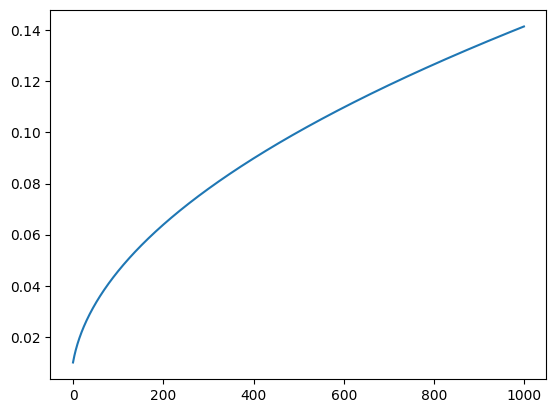

In [13]:
sigma = beta.sqrt()
plt.plot(sigma); # ammount of std of the noise at each step

## alphabar: [1.-beta].cumprod(0)

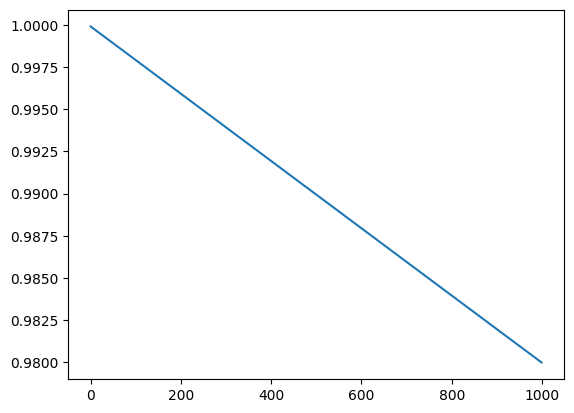

In [13]:
alpha = 1.-beta # alpha = its cumprod is the weight that defines of how much of the original img we keep
plt.plot(alpha);

In [ ]:
alpha = 1.-beta # alpha = its cumprod is the weight that defines of how much of the original img we keep
alphabar = alpha.cumprod(dim=0)
plt.plot(alphabar);

# cumulative prod cuz if we add noise n times we have to multiply together that ammount of noise to get the total ammount of noise added over the n steps
# eg: N(m1,1) + N(m2,1) = 2N((2m1+m2),1) = N(0,2**2)
# in the beginning we keep all img at the end we lose all of it

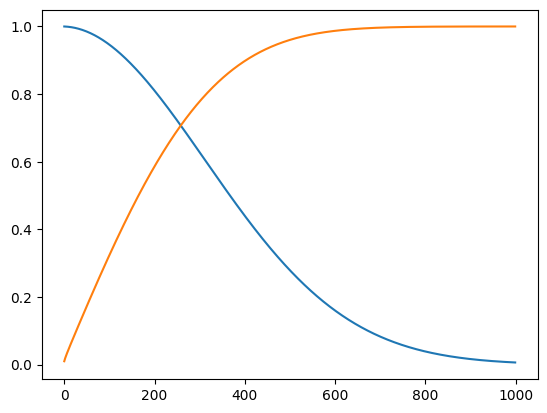

In [15]:
shift = alphabar.sqrt()
scale = (1.-alphabar).sqrt()

plt.plot(shift); # how much we keep of original img over time
plt.plot(scale); # variance of noise we add to img over time

In [15]:
class DDPM(TrainCB):
    '''
    goal of the cb: setup batch to train data
    '''
    order = DeviceCB.order+1
    def __init__(self, n_steps, β_min, β_max):
        super().__init__()
        self.n_steps, self.β_min, self.β_max = n_steps, β_min, β_max                   
        self.β = torch.linspace(self.β_min, self.β_max, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0) 
        self.σ = self.β.sqrt()
        
    def before_batch(self, learn):
        device = learn.batch[0].device
        self.ᾱ = self.ᾱ.to(device)

        x_batch = learn.batch[0]
        batch_size = x_batch.shape[0]
        
        # sample wn to be applied to imgs
        ϵ = torch.randn(x_batch.shape, device=device)
        
        # Select random timestep for each obs in batch. t will define how much:
        # - we keep of the original img via shifting (shift = f(t) = ᾱ_t.sqrt())
        # - noise we add to img by scaling the variance (scale = f(t) = (1-ᾱ_t).sqrt())
        t = torch.randint(0, self.n_steps, (batch_size,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        
        # Add noise to img ϵ ~ N(0,1) already sampled
        # - scaled by (1-ᾱ_t).sqrt() -> ϵ ~ N(0,(1-ᾱ_t).sqrt())
        # - shifted by ᾱ_t.sqrt() * x_batch -> ϵ ~ N(ᾱ_t.sqrt() * x_batch, (1-ᾱ_t).sqrt())
        shift = ᾱ_t.sqrt() * x_batch # center it on original img, of which we keep a certain proportion ᾱ_t.sqrt()
        scale = (1-ᾱ_t).sqrt() # but we add a certain ammount of variance inversly proportional of how much we kept of original img
        x_batch =  shift + scale * ϵ
        
        # input to model: (noisy-image, timestep); label: the noise 
        learn.batch = ((x_batch, t), ϵ)
        # the idea is that a nn trained this way is able to take:
        # a noisy img -> isolate noise -> drop noise to get better img
        # the nn is learning: p_θ(x_t-1 | x_t) : the reverse process
        # from noise to pic, t=T wn, t=0 = original img

    def predict(self, learn):
        # HuggingFace model api compute preds and store them in .sample  
        learn.preds = learn.model(*learn.batch[0]).sample
        # .sample cuz HuggingFace model have its own api to get preds
        # nice that with TrainCB we can override predict to make 
        # easy usage of predict method even if we need to pass thru HF        
        # alternative: 
        # class UNet(Unet2DModel):
        #     def forward(self, x): return super().forward.(*x).sample
    
    
    @torch.no_grad()
    def sample(self, model, size):
        device = next(model.parameters()).device
        
        # starting fully wn img, x_t will iteratively refined to make it "real"
        x_t = torch.randn(size, device=device)
        preds = []
        for t in reversed(range(self.n_steps)): # from T to 0 
            # sample noise; this step contains base case for when we end generation
            if t > 0: # still not done
                z = torch.randn(x_t.shape).to(device) 
            else: # base case for when we end generation: do not add noise cuz we already have final pic
                z = torch.zeros(x_t.shape).to(device)
            
            # compute scaling coefficients 
            if t > 0:
                ᾱ_t1 = self.ᾱ[t-1]  
            else:
                ᾱ_t1 = torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            
            # given the img x_t got at prev t, we get new pred  
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long) # get bs tensor of ts, to be fed as inpt
            noise_pred = model(x_t, t_batch).sample #learn.model(x_t, t_batch).sample
            
            # remove predicted noise from x_t
            x_0_hat = ((x_t - (b̄_t.sqrt() * noise_pred)) / self.ᾱ[t].sqrt()).clamp(-1,1)
            
            # how much we keep of new img x_0_hat
            x0_coeff = ᾱ_t1.sqrt() * (1-self.α[t]) / b̄_t

            # how much we keep of prev img x_(t-1)
            xt_coeff = self.α[t].sqrt() * b̄_t1 / b̄_t
            
            # mean of new xt = LC (weighted avg) of x_0_hat and x_(t-1) + reparam trick 
            mean = (x0_coeff* x_0_hat) + (xt_coeff * x_t)
            scale = self.σ[t] # it decreases the more we get to 0 (real img), at 0 z = 0s
            x_t =  mean + scale * z # x_t is a weighted average of the prediction for x_0_hat and the previous timestep x_(t-1) (plus new noise)
            
            preds.append(x_t.cpu())
        return preds

In [16]:
lr = 5e-3
epochs = 5
tmax = epochs * len(dls.train)
scheduler = partial(torch.optim.lr_scheduler.OneCycleLR, total_steps=tmax, max_lr=lr)
ddpm_cb = DDPM(n_steps=1000, β_min= 0.0001, β_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricCB(), BatchSchedCB(scheduler)]

## Idea about adam:
always increase eps = 1e-5 -> otherwise lr huge, why lr huge? small denominator somewhere that leads to large value which might lead to gradients go to nan

In [17]:
opt_func = partial(optim.Adam, eps=1e-5)

##  Idea about resnets:
Initialize the weights of the non-skip connections to 0 (or very small weights) s.t. in the beginning of the training the gradient is free to flow from out
to input without blocks. This allows early layers to recieve good gradients since the beginning of the training. During training then the weights of the non-skip blocks get gradient -> are modified -> their influence get stronger -> improve performance and we are sure that we don't get vanishing grads if the net is too deep. 

In [18]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [19]:
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [20]:
learn.fit(epochs)

KeyboardInterrupt: 

In [ ]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [ ]:
#torch.save(learn.model, mdl_path/'fashion_mnist_ddpm.pkl')

In [ ]:
learn.model = torch.load(mdl_path/'fashion_mnist_ddpmMineCPU.pkl')

# Inference

In [ ]:
set_seed(42)
n_samples = 1
samples = ddpm_cb.sample(learn.model, (n_samples, 1, 32, 32))
len(samples)

In [ ]:
plt.imshow(samples[-1].squeeze())

In [ ]:
set_seed(42)
n_samples = 10
samples = ddpm_cb.sample(learn.model, (n_samples, 1, 32, 32))
len(samples)

In [ ]:
showImgGroup([samples[-1][i] for i in range(n_samples)], (3,3))

Animation

In [ ]:
# !conda install -c conda-forge ffmpeg
%matplotlib auto
import matplotlib.animation as animation
from IPython.display import display, HTML
from fastcore.foundation import L


fig,ax = plt.subplots(figsize=(3,3))
def _show_i(i): return show_image(-samples[i][9], ax=ax, animated=True).get_images()
r = L.range(800,990, 5)+L.range(990,1000)+[999]*10
ims = r.map(_show_i)

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=3000)
display(HTML(animate.to_html5_video()))

Note that I only take the steps between 800 and 1000 since most of the previous steps are actually quite noisy. This is a limitation of this noise scheduler formulation used for small images, and papers like Improved DDPM use cosine scheduler

## ALWAYS START FROM SIMPLE SMALL DATASET

# Mixed precision
Idea: to get computation faster, instead of working on float32 we could work on float16, but we would loose too much expressive power if we apply this mindlessly on the whole net, so we mix it/apply cast where we can

In [ ]:
# let's being by extracting the "noisification" ie the forward process of ddpm
def noisify(x0, ᾱ): # takes
    '''
    given a batch and ᾱ, creates:
    (x:(x_t, t), y:ϵ) <- batch for training 
    '''
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [ ]:
xb[0][...,].shape

An alternative to putting the forward process inside the a callback and calling it in before_batch(), we could insert the nosify procedure inside a collate function! Recall that the collate function: f used by DataLoader to create batch from idxs.
The dataloader contains a list of data, this data can be grabbed via idxs
and glued to form a batch via collate, the collate thus can contain preprocessing.\

input: [(xi,yi), (xj,yj), ...] \
output: (tensor(X_batch), tensor(Y_batch))


In [ ]:
def collate_ddpm(batch):
    '''
    input: [(xi,yi), (xj,yj), ...] 
    output: (tensor(X_batch_with noise), tensor(noise))
    '''
    return noisify(default_collate(batch)[x], alphabar)

def dataLoader_ddpm(dataset): 
    return DataLoader(dataset, batch_size=bs, collate_fn=collate_ddpm) # num_workers

In [ ]:
dataloaders = DataLoaders(dataLoader_ddpm(tds["train"]), dataLoader_ddpm(tds["test"]))

In [ ]:
len(dataloaders.train) # <- num batches

The previous steps were just to remove the DDPM CB. (why not, less code!)

Now we implement __Mixed Precision__ as described here: https://pytorch.org/docs/stable/notes/amp_examples.html

In [ ]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn):
        self.scaler = torch.cuda.amp.GradScaler()
        
    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()
        
    def after_loss(self, learn):
        self.autocast.__exit__(None,None,None)
        
    def backward(self, learn):
        self.scaler.scale(learn.loss).backward()
        
    def step(self, learn):
        # as required in docs: 
        # https://pytorch.org/docs/stable/notes/amp_examples.html
        self.scaler.step(learn.opt)
        self.scaler.update()

# the idea is that pytorch implements mixed precision with a context 
# manager: 
# with autocast(device_type='cuda', dtype=torch.float16):
# we call the .__enter__() of that contex manager manually

In [ ]:
# since we use MixedPrecisionn gpu must be very busy: a lot of compute at the same time
# so we increase the bs
# thus less opt.steps() -> need to increase n epochs and lr to converge at same speed 

from torch.optim.lr_scheduler import OneCycleLR


lr = 1e-2
epochs = 8
tmax = epochs * len(dataloaders.train)
sched = partial(OneCycleLR, max_lr = lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricCB(), BatchSchedCB(sched)]
opt_func = partial(optim.Adam, eps=1e-5)
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

To use MixedPrecision we could also use HuggingFace lib!
They have an Accelerate lib that allows to accelerate the train loop, 
enabling mixed precision, it also allows multi-gpu training, tpu training etc

In [ ]:
# !pip install accelerate
from accelerate import Accelerator

In [ ]:
class AccellerateCB(TrainCB):
    '''
    n_inp = number of inputs to the model eg DDPM take 2 inputs: the image and the timestamp t
    '''
    order = DeviceCB.order + 10
    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp = n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model, learn.opt, learn.dls.train, learn.dls.valid = self.acc(prepare(learn.model, 
                                                    learn.opt, learn.dls.train, learn.dls.valid))
        
    def backward(self, learn):
        self.acc.backward(learn.loss)

Another idea that we can apply to simplify our code is to pass data in the correct form instead of: \
learn.model(*learn.batch[0]).sample

In [ ]:
# let's being by extracting the "noisification" ie the forward process of ddpm
def noisify(x0, ᾱ): # takes
    '''
    given a batch and ᾱ, creates:
    returns: x_t, t, ϵ  
    '''
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε # return changed

In [ ]:
# reinstantiate DataLoaders with new noisify
dataloaders = DataLoaders(dataLoader_ddpm(tds["train"]), dataLoader_ddpm(tds["test"]))

In [ ]:
class DDPMCB2(Callback):
    def after_predict(self, learn):
        learn.preds = learn.preds.sample # cuz of huggingFace api

In [ ]:
cbs = [DeviceCB(), ProgressCB(plot=True), MetricCB(), BatchSchedCB(sched), DDPMCB2()]
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

# A sneaky trick to train faster:

In [ ]:
class MultiDL:
    '''
    A dataloader that returns twice the same batch.
    why? -> when u load a batch with preprocessing stuff, it takes a while
    to open data, pre process it etc, and all these things are done on cpu
    so better to keep the batch in mem and feed it twice to the net
    okay from theoretical pov, speeds up convergence/train -> faster iterations!!
    faster iterations == more experiments, more experiments == win
    
    '''
    def __init__(self, dl, mult=2):
        self.dl, self.mult = dl, mult
        
    def __len__(self):
        return len(self.dl)*self.mult
    
    def __iter__(self):
        for batch in self.dl:
            for i in range(self.mult):
                yield batch